In [48]:
pip install keras-tuner


In [ ]:
import tensorflow as tf
from tensorflow import keras
from kerastuner.tuners import Hyperband
from kerastuner.engine.hyperparameters import HyperParameters

In [ ]:
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape(-1, 28, 28, 1).astype('float32') / 255.0
test_images = test_images.reshape(-1, 28, 28, 1).astype('float32') / 255.0

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('conv_layers', 2, 5)):
        model.add(keras.layers.Conv2D(
            filters=hp.Int(f'filters_{i}', 32, 256),
            kernel_size=hp.Choice(f'kernel_{i}', [3, 5]),
            activation='relu'
        ))
        model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(keras.layers.Flatten())
    for i in range(hp.Int('dense_layers', 2, 5)):
        model.add(keras.layers.Dense(
            units=hp.Int(f'units_{i}', 32, 256),
            activation='relu'
        ))
        model.add(keras.layers.Dropout(rate=hp.Float(f'dropout_{i}', 0.0, 0.5, step=0.1)))

    model.add(keras.layers.Dense(10, activation='softmax'))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [1e-4, 5e-4, 1e-3])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=7,
    factor=3,
    directory='my_dir',
    project_name='mnist_classification',
    max_consecutive_failed_trials=5
)


Reloading Tuner from my_dir/mnist_classification/tuner0.json


In [ ]:
tuner.search(train_images, train_labels, epochs=7, validation_split=0.2)
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 8 Complete [00h 00m 01s]

Best val_accuracy So Far: 0.9886666536331177
Total elapsed time: 01h 23m 33s


In [ ]:
best_hyperparameters.values

{'conv_layers': 3,
 'filters_0': 138,
 'kernel_0': 5,
 'filters_1': 138,
 'kernel_1': 5,
 'dense_layers': 4,
 'units_0': 188,
 'dropout_0': 0.2,
 'units_1': 151,
 'dropout_1': 0.0,
 'learning_rate': 0.0001,
 'filters_2': 167,
 'kernel_2': 3,
 'filters_3': 62,
 'kernel_3': 5,
 'filters_4': 42,
 'kernel_4': 5,
 'units_2': 142,
 'dropout_2': 0.4,
 'units_3': 139,
 'dropout_3': 0.4,
 'units_4': 101,
 'dropout_4': 0.4,
 'tuner/epochs': 8,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [50]:
import tensorflow as tf
from tensorflow import keras

model = keras.Sequential()
for i in range(best_hyperparameters['conv_layers']):
    model.add(keras.layers.Conv2D(
        filters=best_hyperparameters[f'filters_{i}'],
        kernel_size=best_hyperparameters[f'kernel_{i}'],
        activation='relu'
    ))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(keras.layers.Flatten())
for i in range(best_hyperparameters['dense_layers']):
    model.add(keras.layers.Dense(
        units=best_hyperparameters[f'units_{i}'],
        activation='relu'
    ))
    model.add(keras.layers.Dropout(rate=best_hyperparameters[f'dropout_{i}']))

model.add(keras.layers.Dense(10, activation='softmax'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=best_hyperparameters['learning_rate']),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history=model.fit(train_images, train_labels, epochs=best_hyperparameters['tuner/epochs'], initial_epoch=best_hyperparameters['tuner/initial_epoch'],validation_data=(test_images, test_labels))

# # Evaluate the model on test data
# test_loss, test_accuracy = model.evaluate(test_images, test_labels)
# print(f"Test Accuracy: {test_accuracy}")
# print(f"Test Loss: {test_loss}")


Epoch 1/8
1875/1875 [==============================] - 467s 217ms/step - loss: 0.5569 - accuracy: 0.8194 - val_loss: 0.0802 - val_accuracy: 0.9769
Epoch 2/8
1875/1875 [==============================] - 414s 221ms/step - loss: 0.1236 - accuracy: 0.9676 - val_loss: 0.0522 - val_accuracy: 0.9854
Epoch 3/8
1875/1875 [==============================] - 401s 214ms/step - loss: 0.0801 - accuracy: 0.9789 - val_loss: 0.0368 - val_accuracy: 0.9889
Epoch 4/8
1875/1875 [==============================] - 409s 218ms/step - loss: 0.0591 - accuracy: 0.9849 - val_loss: 0.0379 - val_accuracy: 0.9892
Epoch 5/8
1875/1875 [==============================] - 383s 204ms/step - loss: 0.0372 - accuracy: 0.9907 - val_loss: 0.0302 - val_accuracy: 0.9906
Epoch 7/8
1875/1875 [==============================] - 391s 208ms/step - loss: 0.0297 - accuracy: 0.9922 - val_loss: 0.0284 - val_accuracy: 0.9914
Epoch 8/8
1875/1875 [==============================] - 395s 211ms/step - loss: 0.0252 - accuracy: 0.9935 - val_loss: 0

In [ ]:
# test_loss, test_accuracy = best_model.evaluate(test_images, test_labels)
# print(f"Test Accuracy: {test_accuracy}")


313/313 [==============================] - 24s 76ms/step - loss: 0.0327 - accuracy: 0.9896
Test Accuracy: 0.9896000027656555


In [ ]:
best_model

In [51]:
history.history

{'loss': [0.556928277015686,
  0.12355846911668777,
  0.0801350399851799,
  0.05905294045805931,
  0.0483357235789299,
  0.037241753190755844,
  0.029664667323231697,
  0.02522665075957775],
 'accuracy': [0.8194000124931335,
  0.9676166772842407,
  0.9789333343505859,
  0.9849166870117188,
  0.9874666929244995,
  0.9906833171844482,
  0.9921666383743286,
  0.9935333132743835],
 'val_loss': [0.08023905009031296,
  0.05216047912836075,
  0.03683878853917122,
  0.03791666030883789,
  0.02985384501516819,
  0.03017403930425644,
  0.028447235003113747,
  0.02684820629656315],
 'val_accuracy': [0.9768999814987183,
  0.9854000210762024,
  0.9889000058174133,
  0.9891999959945679,
  0.991599977016449,
  0.9905999898910522,
  0.9914000034332275,
  0.9930999875068665]}

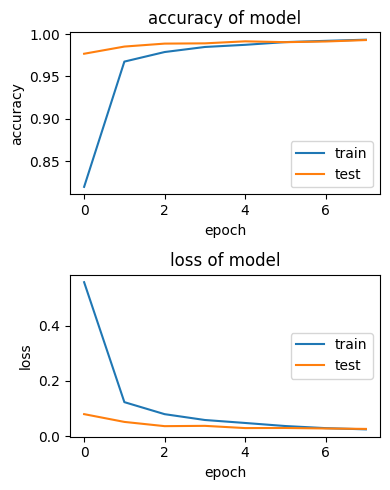

In [52]:
from matplotlib import pyplot as plt
plt.figure(figsize=(4, 5))

plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('accuracy of model')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='lower right')

# Plot training & validation loss values
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss of model')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='center right')
plt.tight_layout()
plt.show()